# Building a CNN model to identify butterfly/moth species

In [153]:
#Set up(Important libraries)
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.preprocessing import image

## Preparing the datasets

In [58]:
#Dataset paths
data_dir = 'D:\\Pokemon Deep Learning\\data2\\'
train_dir = os.path.join(data_dir, 'training_data')
validation_dir = os.path.join(data_dir, 'valid_data')
test_dir = os.path.join(data_dir, 'testing_data')

In [59]:
#Datasets parameters
BATCH_SIZE = 32
IMG_SIZE = (224,224)

In [102]:
#Datasets with keras
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1426 files belonging to 12 classes.
Found 60 files belonging to 12 classes.
Found 60 files belonging to 12 classes.


In [104]:
# Get class names immediately after creation
class_names = train_dataset.class_names

['ADONIS',
 'AFRICAN GIANT SWALLOWTAIL',
 'BANDED ORANGE HELICONIAN',
 'BANDED PEACOCK',
 'COMET MOTH',
 'LARGE MARBLE',
 'MADAGASCAN SUNSET MOTH',
 'MILBERTS TORTOISESHELL',
 'VICEROY',
 'WHITE LINED SPHINX MOTH',
 'YELLOW SWALLOW TAIL',
 'ZEBRA LONG WING']

In [105]:
#Configure dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Building the CNN model

In [64]:
#Use data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [40]:
#Rescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [65]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [66]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [67]:
#Freeze the convolutional base
base_model.trainable = False

In [68]:
#Classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [69]:
# Creating prediction layer with 12 options
prediction_layer = tf.keras.layers.Dense(12, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 12)


In [70]:
# Building the CNN model with MobileNet
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [71]:
#compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [72]:
# Checking the architecture of the model
print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │        15,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


## Model training

In [73]:
# Baseline performance
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 673ms/step - accuracy: 0.0972 - loss: 2.9102


In [74]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.02
initial accuracy: 0.08


In [75]:
#train the model
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 811ms/step - accuracy: 0.1165 - loss: 2.9894 - val_accuracy: 0.1333 - val_loss: 2.4356
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 803ms/step - accuracy: 0.1711 - loss: 2.4034 - val_accuracy: 0.3167 - val_loss: 2.0240
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 823ms/step - accuracy: 0.3407 - loss: 1.9884 - val_accuracy: 0.5333 - val_loss: 1.6863
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 817ms/step - accuracy: 0.5209 - loss: 1.6285 - val_accuracy: 0.6667 - val_loss: 1.4231
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 830ms/step - accuracy: 0.6156 - loss: 1.4084 - val_accuracy: 0.7833 - val_loss: 1.2107
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 850ms/step - accuracy: 0.7239 - loss: 1.1829 - val_accuracy: 0.8500 - val_loss: 1.0390
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 848ms/step - accuracy: 0.7885 - loss: 1.0154 - val_accuracy: 0.8500 - val_loss: 0.9055
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 840ms/step - accuracy: 0.8217 - loss: 0.8947 - val_accu

## Observing Performance

In [76]:
#learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [77]:
loss = history.history['loss']
val_loss = history.history['val_loss']

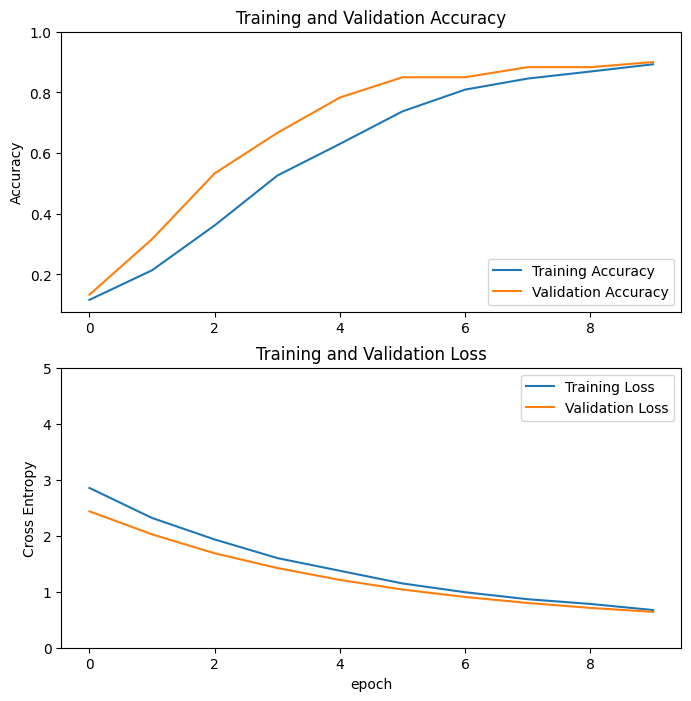

In [78]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [79]:
#Fine tune
base_model.trainable = True

In [80]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [81]:
# Fine-tune from this layer onwards
fine_tune_at = 100

In [82]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [83]:
#Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │        15,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 1,876,812 (7.16 MB)

 Non-trainable params: 396,544 (1.51 MB)

None


In [84]:
#Continue training the model
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.5019 - loss: 1.4504 - val_accuracy: 0.8833 - val_loss: 0.4976
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7440 - loss: 0.9028 - val_accuracy: 0.9000 - val_loss: 0.4139
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8745 - loss: 0.6035 - val_accuracy: 0.9167 - val_loss: 0.3494
Epoch 13/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9450 - loss: 0.3953 - val_accuracy: 0.9000 - val_loss: 0.2992
Epoch 14/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9451 - loss: 0.3051 - val_accuracy: 0.9000 - val_loss: 0.2675
Epoch 15/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9555 - loss: 0.2278 - val_accuracy: 0.9000 - val_loss: 0.2358
Epoch 16/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9761 - loss: 0.1711 - val_accuracy: 0.9000 - val_loss: 0.2084
Epoch 17/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9785 - loss: 0.1350 - val_accuracy: 0.9000 - v

In [85]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

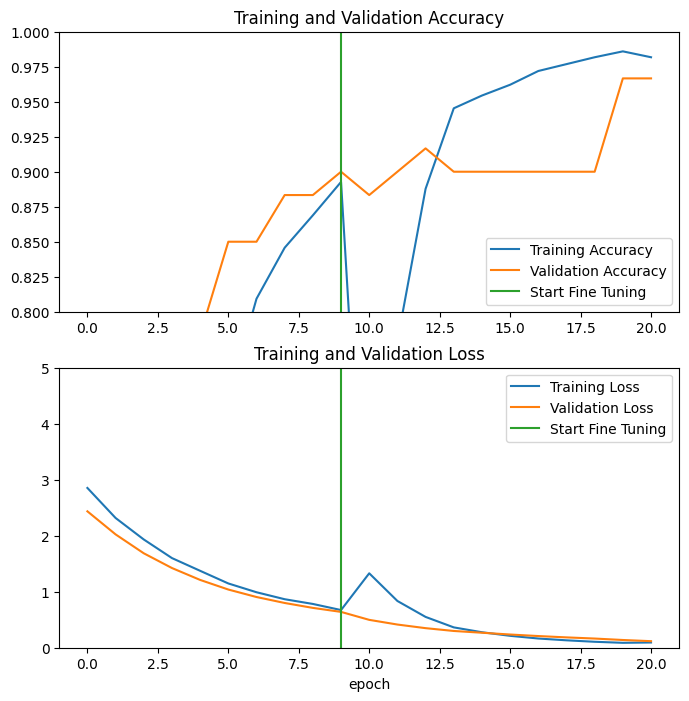

In [86]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [87]:
#evaluation and predictions
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 746ms/step - accuracy: 0.9785 - loss: 0.0844
Test accuracy : 0.9833333492279053


# Manual Testing

In [88]:
def preprocess_image(img_path, img_size):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    return img_array

In [114]:
def predict_image(model, img_path, img_size, class_names):
    processed_img = preprocess_image(img_path, img_size)
    
    # If you used data augmentation or other preprocessing, apply it here
    # processed_img = data_augmentation(processed_img)
    
    # If you used preprocess_input from MobileNetV2, apply it here
    # processed_img = preprocess_input(processed_img)
    
    predictions = model.predict(processed_img)
    
    # If your model outputs logits (i.e., you used from_logits=True in your loss function)
    predicted_class = np.argmax(predictions[0])
    confidence = tf.nn.softmax(predictions[0])
    
    # If your model already outputs probabilities, use this instead:
    # predicted_class = np.argmax(predictions[0])
    # confidence = np.max(predictions[0])
    
    return class_names[predicted_class], confidence[predicted_class].numpy()

In [125]:
# Path to your test image
img_path = 'D:\\Pokemon Deep Learning\\data2\\ManualTesting\\099.jpg'

# Make prediction
predicted_class, confidence = predict_image(model, img_path, IMG_SIZE, class_names)

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted class: ADONIS
Confidence: 0.20


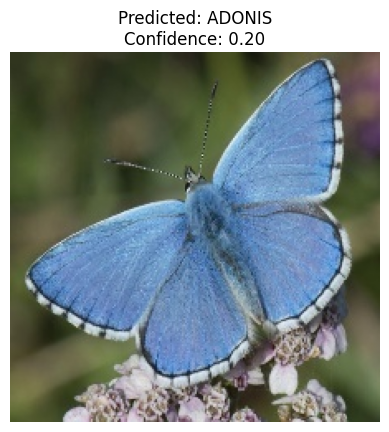

In [126]:
def display_prediction(img_path, predicted_class, confidence):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.show()

# After making a prediction
display_prediction(img_path, predicted_class, confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Image: 003-a.jpg
Predicted class: ADONIS
Confidence: 0.20
--------------------


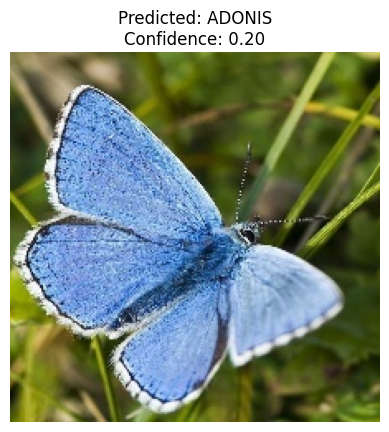

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Image: 003.jpg
Predicted class: BANDED PEACOCK
Confidence: 0.20
--------------------


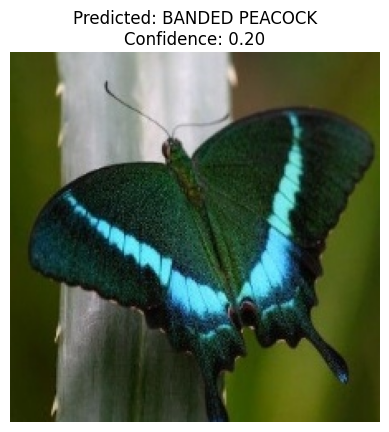

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Image: 019.jpg
Predicted class: BANDED ORANGE HELICONIAN
Confidence: 0.19
--------------------


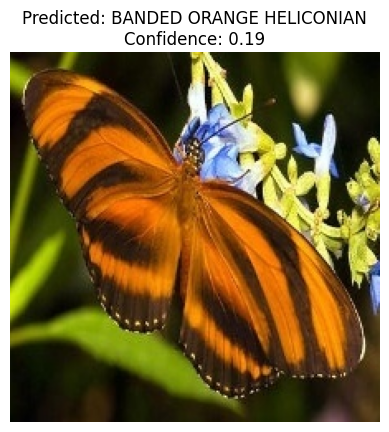

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Image: 023.jpg
Predicted class: LARGE MARBLE
Confidence: 0.19
--------------------


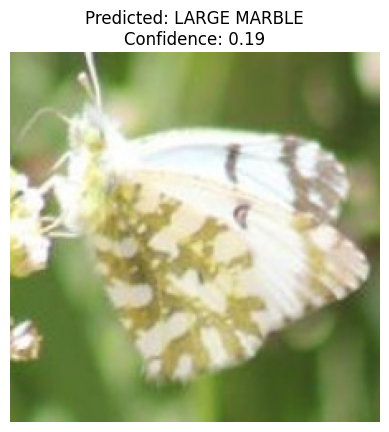

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: 040.jpg
Predicted class: COMET MOTH
Confidence: 0.18
--------------------


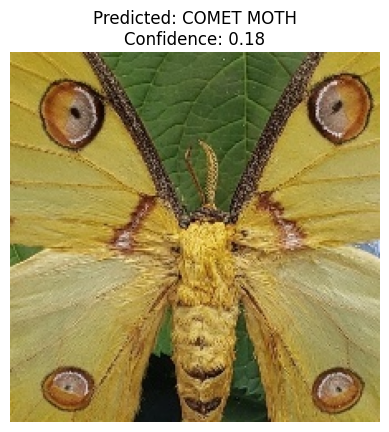

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Image: 049.jpg
Predicted class: AFRICAN GIANT SWALLOWTAIL
Confidence: 0.20
--------------------


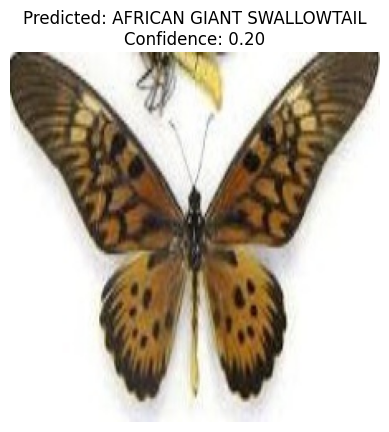

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Image: 053.jpg
Predicted class: AFRICAN GIANT SWALLOWTAIL
Confidence: 0.19
--------------------


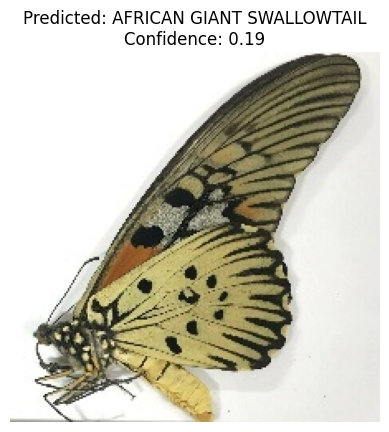

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Image: 059.jpg
Predicted class: LARGE MARBLE
Confidence: 0.19
--------------------


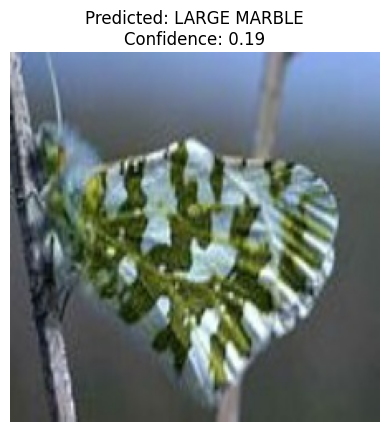

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Image: 079.jpg
Predicted class: COMET MOTH
Confidence: 0.20
--------------------


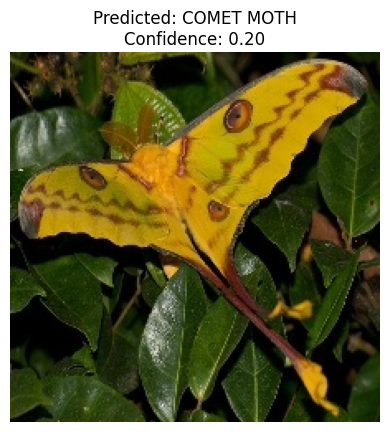

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Image: 080.jpg
Predicted class: BANDED PEACOCK
Confidence: 0.14
--------------------


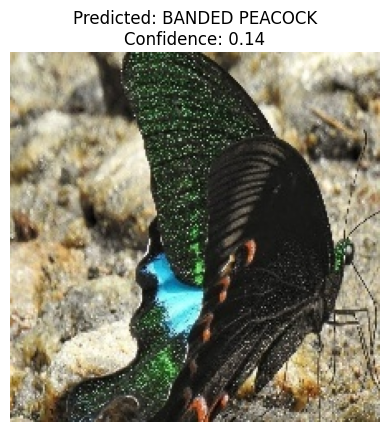

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Image: 095.jpg
Predicted class: MADAGASCAN SUNSET MOTH
Confidence: 0.20
--------------------


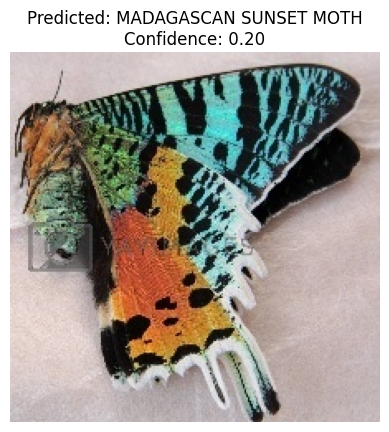

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Image: 099.jpg
Predicted class: ADONIS
Confidence: 0.20
--------------------


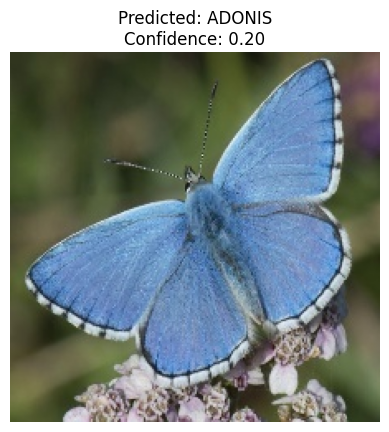

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Image: 103.jpg
Predicted class: MADAGASCAN SUNSET MOTH
Confidence: 0.20
--------------------


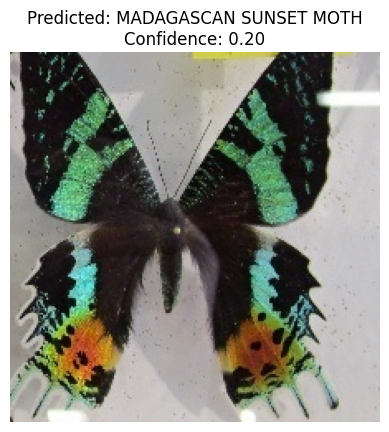

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Image: 105.jpg
Predicted class: BANDED ORANGE HELICONIAN
Confidence: 0.19
--------------------


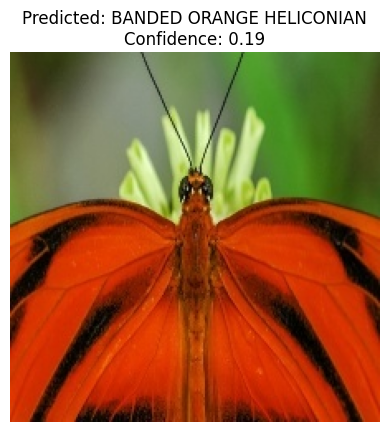

In [127]:
test_image_dir = 'D:\\Pokemon Deep Learning\\data2\\ManualTesting'

for img_name in os.listdir(test_image_dir):
    img_path = os.path.join(test_image_dir, img_name)
    predicted_class, confidence = predict_image(model, img_path, IMG_SIZE, class_names)
    print(f"Image: {img_name}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")
    print("--------------------")
    
    # Uncomment to display each image
    display_prediction(img_path, predicted_class, confidence)

In [128]:
import tensorflow as tf

def get_all_confidences(model, img_array):
    predictions = model.predict(img_array)
    
    # If your model outputs logits, apply softmax
    if model.layers[-1].activation != tf.nn.softmax:
        predictions = tf.nn.softmax(predictions).numpy()
    
    return predictions[0]  # Return probabilities for the first (and only) image

In [130]:
img_path = 'D:\\Pokemon Deep Learning\\data2\\ManualTesting\\049.jpg'
img_array = preprocess_image(img_path, IMG_SIZE)

confidences = get_all_confidences(model, img_array)

# Print confidences for all classes
for i, confidence in enumerate(confidences):
    print(f"Class {class_names[i]}: {confidence:.4f}")

# Get the top predicted class
predicted_class_index = np.argmax(confidences)
predicted_class = class_names[predicted_class_index]
top_confidence = confidences[predicted_class_index]

print(f"\nTop prediction: {predicted_class} with confidence {top_confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Class ADONIS: 0.0729
Class AFRICAN GIANT SWALLOWTAIL: 0.1981
Class BANDED ORANGE HELICONIAN: 0.0729
Class BANDED PEACOCK: 0.0729
Class COMET MOTH: 0.0729
Class LARGE MARBLE: 0.0729
Class MADAGASCAN SUNSET MOTH: 0.0729
Class MILBERTS TORTOISESHELL: 0.0729
Class VICEROY: 0.0729
Class WHITE LINED SPHINX MOTH: 0.0729
Class YELLOW SWALLOW TAIL: 0.0729
Class ZEBRA LONG WING: 0.0729

Top prediction: AFRICAN GIANT SWALLOWTAIL with confidence 0.1981


## Using EfficientNet model to try and improve the accuracy of the model

In [156]:
# Creating the base model with EfficientNet
base_model2 = efficientnet.EfficientNetB0(weights='imagenet', 
                                    include_top=False, 
                                    input_shape=(224, 224, 3))

In [157]:
def preprocess_input_efficient(x):
    return efficientnet.preprocess_input(x)

In [158]:
# Building the CNN model with EfficientNet
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input_efficient(x)
x = base_model2(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_efficient = tf.keras.Model(inputs, outputs)

In [159]:
#compile the model
base_learning_rate = 0.0001
model_efficient.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [160]:
# Checking the architecture of the model
print(model_efficient.summary())

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │        15,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,064,943 (15.51 MB)

 Trainable params: 4,022,920 (15.35 MB)

 Non-trainable params: 42,023 (164.16 KB)

None


## Model Training with EfficientNet

In [161]:
# Baseline performance
initial_epochs = 10
loss0, accuracy0 = model_efficient.evaluate(validation_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 895ms/step - accuracy: 0.3264 - loss: 2.0876


In [162]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.08
initial accuracy: 0.33


In [163]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [164]:
#train the model
history = model_efficient.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=early_stopping)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 340s 7s/step - accuracy: 0.6490 - loss: 1.5469 - val_accuracy: 0.8500 - val_loss: 0.6393
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 304s 7s/step - accuracy: 0.9682 - loss: 0.3318 - val_accuracy: 0.9500 - val_loss: 0.1642
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 293s 7s/step - accuracy: 0.9867 - loss: 0.1242 - val_accuracy: 1.0000 - val_loss: 0.0471
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 285s 6s/step - accuracy: 0.9910 - loss: 0.0668 - val_accuracy: 1.0000 - val_loss: 0.0190
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.9936 - loss: 0.0476 - val_accuracy: 1.0000 - val_loss: 0.0140
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 280s 6s/step - accuracy: 0.9984 - loss: 0.0295 - val_accuracy: 1.0000 - val_loss: 0.0092
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 280s 6s/step - accuracy: 0.9947 - loss: 0.0305 - val_accuracy: 1.0000 - val_loss: 0.0068
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 319s 6s/step - accuracy: 0.9986 - loss: 0.0160 - val_accuracy: 1.0000 - v

## Observing Performance of EfficientNet

In [165]:
#learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [166]:
loss = history.history['loss']
val_loss = history.history['val_loss']

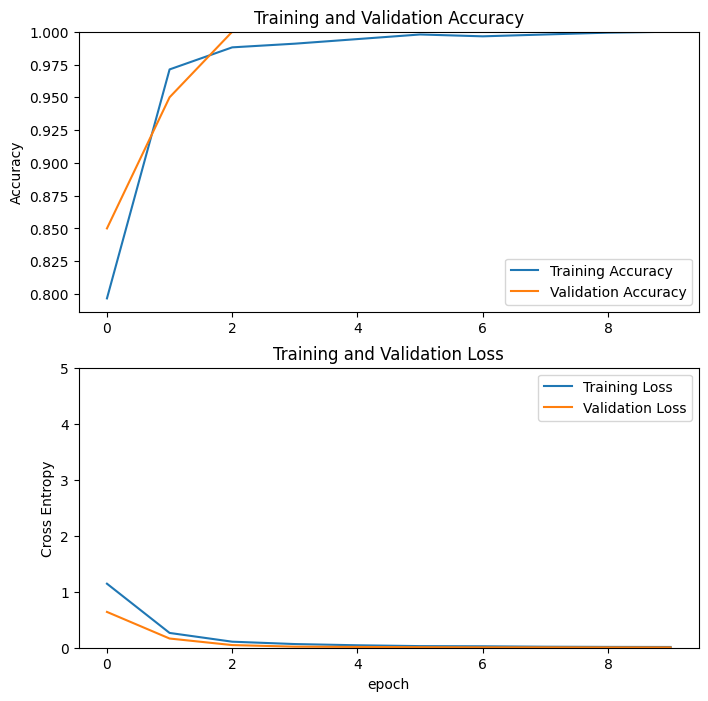

In [167]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Manual Testing of EfficientNet

In [168]:
# Path to your test image
img_path = 'D:\\Pokemon Deep Learning\\data2\\ManualTesting\\099.jpg'

# Make prediction
predicted_class, confidence = predict_image(model_efficient, img_path, IMG_SIZE, class_names)

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: ADONIS
Confidence: 0.20


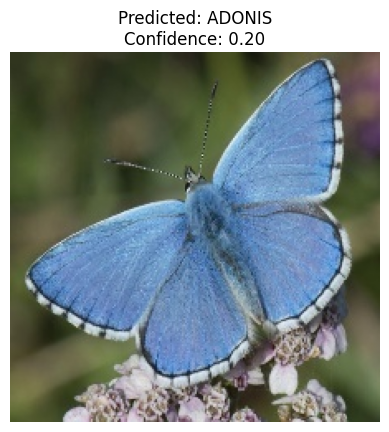

In [169]:
# After making a prediction
display_prediction(img_path, predicted_class, confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Image: 003-a.jpg
Predicted class: ADONIS
Confidence: 0.20
--------------------


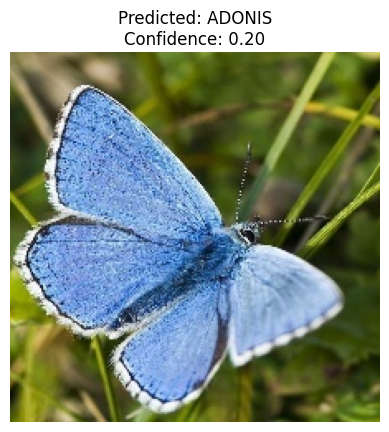

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Image: 003.jpg
Predicted class: BANDED PEACOCK
Confidence: 0.20
--------------------


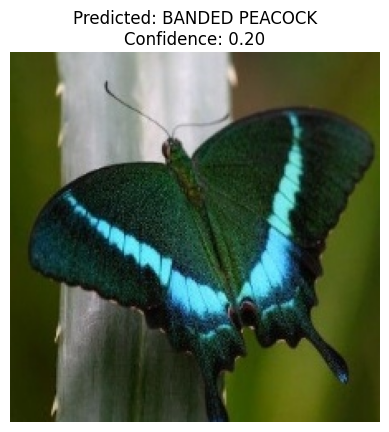

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Image: 019.jpg
Predicted class: BANDED ORANGE HELICONIAN
Confidence: 0.20
--------------------


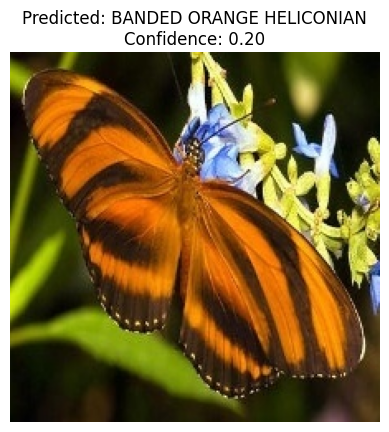

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Image: 023.jpg
Predicted class: LARGE MARBLE
Confidence: 0.20
--------------------


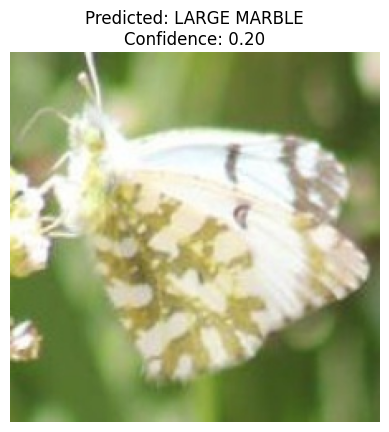

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Image: 040.jpg
Predicted class: COMET MOTH
Confidence: 0.20
--------------------


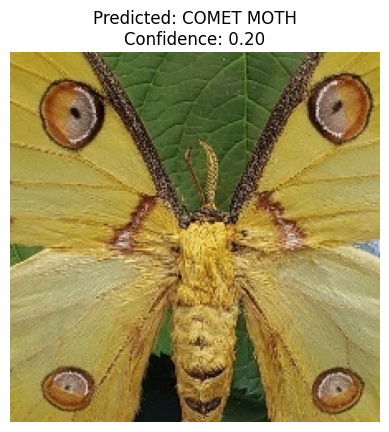

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Image: 049.jpg
Predicted class: AFRICAN GIANT SWALLOWTAIL
Confidence: 0.20
--------------------


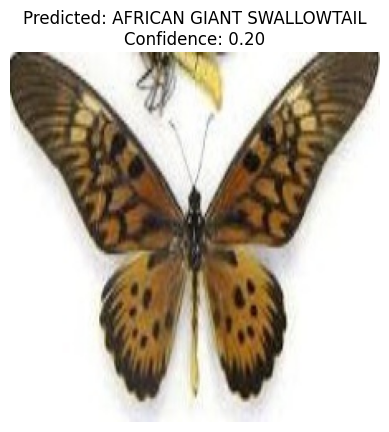

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Image: 053.jpg
Predicted class: AFRICAN GIANT SWALLOWTAIL
Confidence: 0.20
--------------------


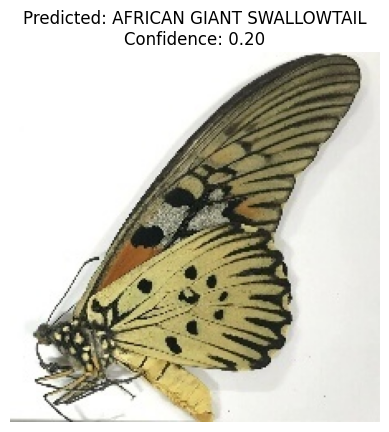

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Image: 059.jpg
Predicted class: LARGE MARBLE
Confidence: 0.20
--------------------


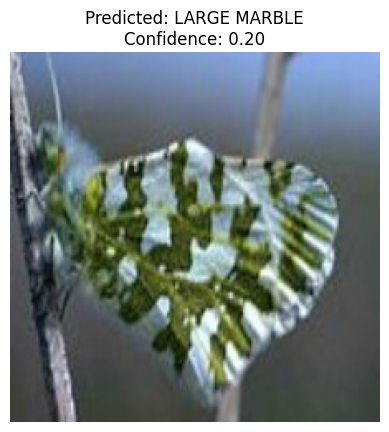

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Image: 079.jpg
Predicted class: COMET MOTH
Confidence: 0.20
--------------------


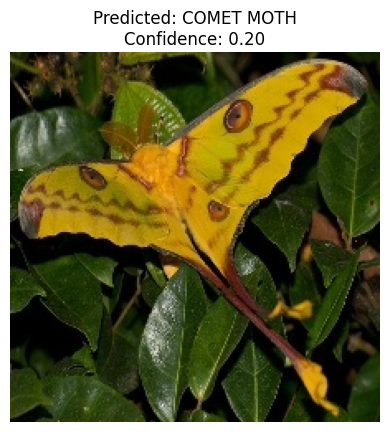

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Image: 080.jpg
Predicted class: BANDED PEACOCK
Confidence: 0.18
--------------------


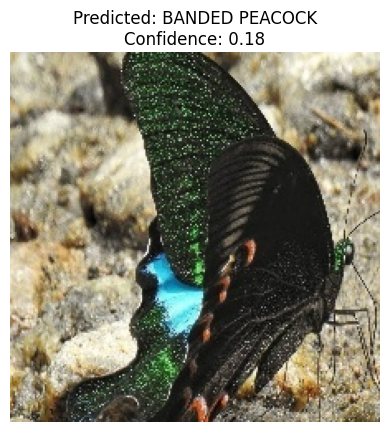

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Image: 095.jpg
Predicted class: MADAGASCAN SUNSET MOTH
Confidence: 0.20
--------------------


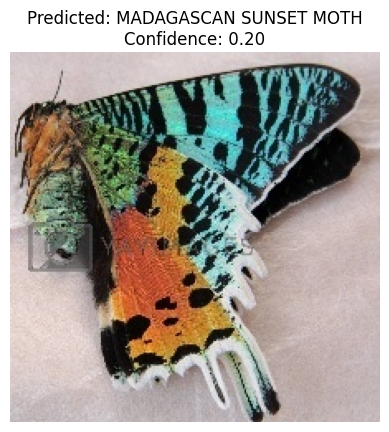

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Image: 099.jpg
Predicted class: ADONIS
Confidence: 0.20
--------------------


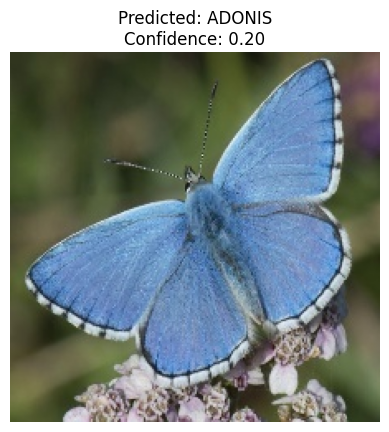

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Image: 103.jpg
Predicted class: MADAGASCAN SUNSET MOTH
Confidence: 0.20
--------------------


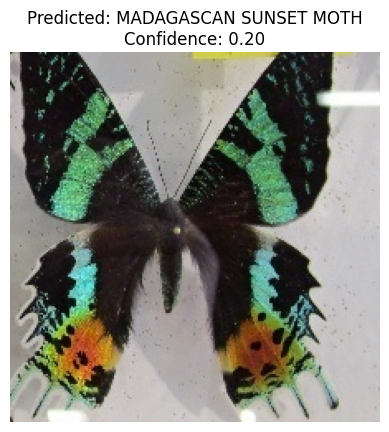

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Image: 105.jpg
Predicted class: BANDED ORANGE HELICONIAN
Confidence: 0.20
--------------------


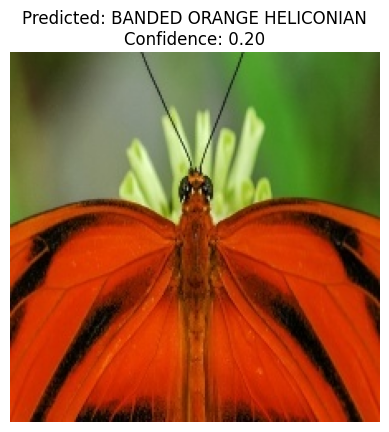

In [171]:
for img_name in os.listdir(test_image_dir):
    img_path = os.path.join(test_image_dir, img_name)
    predicted_class, confidence = predict_image(model_efficient, img_path, IMG_SIZE, class_names)
    print(f"Image: {img_name}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")
    print("--------------------")
    
    # Uncomment to display each image
    display_prediction(img_path, predicted_class, confidence)

## Saving the model

In [173]:
model_efficient.save("D:\\Pokemon Deep Learning\\data2\\butterfly_moth_model.keras")